In [1]:
from SimPEG import Mesh, Utils, Maps, PF, Regularization, Optimization, Directives, DataMisfit, InvProblem, Inversion
from SimPEG.Utils import mkvc, sdiag
import numpy as np
import scipy as sp
import os
%pylab inline
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import GeoToolkit

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG.Utils import sdiag, speye, kron3
 


def Rz(theta):
    """Rotation matrix about z axis"""
    Rz = np.vstack((np.r_[np.cos((theta)),
                          -np.sin((theta)), 0],
                   np.r_[np.sin((theta)),
                         np.cos((theta)), 0],
                   np.r_[0, 0, 1]))
    return Rz
                          
def Ry(theta):
    """Rotation matrix about y axis"""
    Ry = np.vstack( (np.r_[np.cos((theta)), 0,
                     np.sin((theta))],
                   np.r_[0, 1, 0],
               np.r_[-np.sin((theta)), 0,
                     np.cos((theta))]))

    return Ry

def ddx(n,vals):
    """Define 1D averaging operator from cell-centers to nodes."""
    ddx = (
        sp.sparse.spdiags(
            (np.ones((n, 1)) * vals).T,
            [-1, 0, 1],
            n , n,
            format="csr"
        ) 
    )
    ddx[-1,:] = ddx[-2,:]
    return ddx


import matplotlib.gridspec as gridspec


def plotVectorSectionsOctree(mesh, m, normal='X', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k', vector=True,
                      title=None, axs=None, actvMap=None, contours=None, fill=True,
                      orientation='vertical', cmap='pink_r'):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    normalInd = {'X': 0, 'Y': 1, 'Z': 2}[normal]
    antiNormalInd = {'X': [1, 2], 'Y': [0, 2], 'Z': [0, 1]}[normal]

    h2d = (mesh.h[antiNormalInd[0]], mesh.h[antiNormalInd[1]])
    x2d = (mesh.x0[antiNormalInd[0]], mesh.x0[antiNormalInd[1]])

    #: Size of the sliced dimension
    szSliceDim = len(mesh.h[normalInd])
    if ind is None:
        ind = int(szSliceDim//2)

    cc_tensor = [None, None, None]
    for i in range(3):
        cc_tensor[i] = np.cumsum(np.r_[mesh.x0[i], mesh.h[i]])
        cc_tensor[i] = (cc_tensor[i][1:] + cc_tensor[i][:-1])*0.5
    slice_loc = cc_tensor[normalInd][ind]

#     if type(ind) not in integer_types:
#         raise ValueError('ind must be an integer')

    #create a temporary TreeMesh with the slice through
    temp_mesh = Mesh.TreeMesh(h2d, x2d)
    level_diff = mesh.max_level - temp_mesh.max_level

    XS = [None, None, None]
    XS[antiNormalInd[0]], XS[antiNormalInd[1]] = np.meshgrid(cc_tensor[antiNormalInd[0]],
                                                             cc_tensor[antiNormalInd[1]])
    XS[normalInd] = np.ones_like(XS[antiNormalInd[0]])*slice_loc
    loc_grid = np.c_[XS[0].reshape(-1), XS[1].reshape(-1), XS[2].reshape(-1)]
    inds = np.unique(mesh._get_containing_cell_indexes(loc_grid))

    grid2d = mesh.gridCC[inds][:, antiNormalInd]
    levels = mesh._cell_levels_by_indexes(inds) - level_diff
    temp_mesh.insert_cells(grid2d, levels)
    tm_gridboost = np.empty((temp_mesh.nC, 3))
    tm_gridboost[:, antiNormalInd] = temp_mesh.gridCC
    tm_gridboost[:, normalInd] = slice_loc

    #interpolate values to mesh.gridCC if not 'CC'
#     if vType in ['F', 'E']:
#     aveOp = 'aveF2CC'
#     Av = getattr(mesh, aveOp)
#     print(Av.shape,actvMap.P.shape, m.shape)

    mx = (actvMap*m[:,0])
    my = (actvMap*m[:,1])
    mz = (actvMap*m[:,2])
    
    m = np.c_[mx, my, mz]
#     m = Av*m

    #interpolate values from mesh.gridCC to grid2d
    ind_3d_to_2d = mesh._get_containing_cell_indexes(tm_gridboost)
    v2d = m[ind_3d_to_2d, :]
    amp = np.sum(v2d**2., axis=1)**0.5
    
    if axs is None:
        fig = plt.figure()
        axs = plt.subplot(111)
    else:
        assert isinstance(axs, matplotlib.axes.Axes), "ax must be an matplotlib.axes.Axes"
        fig = axs.figure

#     out = temp_mesh.plotImage(v2d, ax=ax, grid=grid, showIt=showIt, clim=clim)

    im2 = None
    if fill:
#         im2 = axs.contourf(xx, yy, model,
#                            30, vmin=vmin, vmax=vmax,
#                            cmap=cmap)

        im2 = temp_mesh.plotImage(amp, ax=axs, clim=[vmin, vmax], grid=True)
     
    cbar = None
    ind = amp > 1e-8
    
    xx, yy, vx, vy = temp_mesh.gridCC[ind,0], temp_mesh.gridCC[ind,1], v2d[ind,antiNormalInd[0]], v2d[ind,antiNormalInd[1]]
    axs.quiver(xx[::subFact],
               yy[::subFact],
               vx[::subFact],
               vy[::subFact],
               pivot='mid',
               scale_units="inches", scale=scale, linewidths=(1,),
               edgecolors=(vec),
               headaxislength=0.1, headwidth=10, headlength=30)
    
    return axs, im2, cbar


from scipy.interpolate import griddata

def plotProfile(xyzd, a, b, npts, data=None,
                fig=None, ax=None, plotStr='b.-',
                coordinate_system='local'):
    """
    Plot the data and line profile inside the spcified limits
    """
    def linefun(x1, x2, y1, y2, nx, tol=1e-3):
        dx = x2-x1
        dy = y2-y1

        if np.abs(dx) <= tol:
            y = np.linspace(y1, y2, nx)
            x = np.ones_like(y)*x1
        elif np.abs(dy) <= tol:
            x = np.linspace(x1, x2, nx)
            y = np.ones_like(x)*y1
        else:
            x = np.linspace(x1, x2, nx)
            slope = (y2-y1)/(x2-x1)
            y = slope*(x-x1)+y1
        return x, y

    if fig is None:
        fig = plt.figure(figsize=(6, 9))

        plt.rcParams.update({'font.size': 14})

    if ax is None:
        ax = plt.subplot()

    x, y = linefun(a[0], b[0], a[1], b[1], npts)
    distance = np.sqrt((x-a[0])**2.+(y-a[1])**2.)
    dline = griddata(xyzd[:, :2], xyzd[:, -1], (x, y), method='linear')

    if coordinate_system == 'xProfile':
        distance += a[0]
    elif coordinate_system == 'yProfile':
        distance += a[1]

    ax.plot(distance, dline, plotStr)

    if data is not None:
        dline = griddata(xyzd[:, :2], data, (x, y), method='linear')
        ax.plot(distance, dline, 'r.-')

    ax.set_xlim(distance.min(), distance.max())

    # ax.set_xlabel("Distance (m)")
    # ax.set_ylabel("Magnetic field (nT)")

    #ax.text(distance.min(), dline.max()*0.8, 'A', fontsize = 16)
    # ax.text(distance.max()*0.97, out_linei.max()*0.8, 'B', fontsize = 16)
    # ax.legend(("Observed", "Simulated"), bbox_to_anchor=(0.5, -0.3))
    # ax.grid(True)

    return ax

def plotTopo(xyz, axs=None, fill=True, contour=True, clabel=True, cmap = 'RdBu_r'):
    # Create grid of points
    x = np.linspace(xyz[:, 0].min(), xyz[:, 0].max(), 100)
    y = np.linspace(xyz[:, 1].min(), xyz[:, 1].max(), 100)

    X, Y = np.meshgrid(x, y)

    # Interpolate
    d_grid = griddata(xyz[:, 0:2], xyz[:,2], (X, Y), method='linear')
    
    im, CS= [], []
    if axs is None:
        axs = plt.subplot()
        
    if fill:
        im = axs.contourf(X, Y, d_grid, cmap=cmap)
        
    if contour:
        CS = axs.contour(X, Y, d_grid, colors='k', lw=0.1)
        
        if clabel:
            plt.clabel(CS, inline=1, fontsize=10, fmt='%i')
    return im, CS

def plotMarkers(xyz, azm, dip, ms = 1):
    """
        Function to plot a stratigraphic marker at location xyz
    """
    def Rz(theta):
        """Rotation matrix about z axis"""
        theta = -np.deg2rad(theta+90)
        Rz = np.vstack((np.r_[np.cos((theta)),
                              -np.sin((theta))],
                       np.r_[np.sin((theta)),
                             np.cos((theta))]))
        return Rz

    xtick = np.r_[ms,0]
    ytick = np.r_[0,ms]
    
    for ii in range(xyz.shape[0]):
        
        xx = np.dot(Rz(azm[ii]),xtick) 
        yy = np.dot(Rz(azm[ii]),ytick)
        
        plt.plot(np.r_[xyz[ii,0]- xx[0],xyz[ii,0]+xx[0]], np.r_[xyz[ii,1]-xx[1],xyz[ii,1]+xx[1]], c='r', linewidth=3)
        plt.plot(np.r_[xyz[ii,0], xyz[ii,0]+ yy[0]], np.r_[xyz[ii,1], xyz[ii,1]+yy[1]], c='r', linewidth=3)
        plt.text(xyz[ii,0]-yy[0],xyz[ii,1]-yy[1],str(int(dip[ii])), fontsize=12, ha = 'center', va='center')

In [3]:
# Load Gocad ts surfaces and plot
def read_GOCAD_pl(tsfile):
    """

    Read GOCAD polyline (*.pl) file
    INPUT:
    plfile: Segment surface

    OUTPUT:
    vrts : Array of vertices in XYZ coordinates [n x 3]
    segs : Array of index for segments [m x 2]. 

    Author: @fourndo


    """

    import re

    fid = open(tsfile, 'r')
    line = fid.readline()

    # Skip all the lines until the vertices
    VRTX, SEGS = [], []
    vrtx, segs = [], []
    while not re.match('END\n', line):
        line = fid.readline()

        if re.match('ILINE', line):
            
            if vrtx:
                
                VRTX += [np.r_[vrtx]]
            if segs: 
                SEGS += [np.r_[segs]]
            vrtx = []
            segs = []

        # Run down all the vertices and save in array
        if re.match('VRTX', line):
            l_input = re.split('[\s*]', line)
            temp = np.array(l_input[2:5])
            vrtx.append(temp.astype(np.float))

        # Run down all the vertices and save in array
        if re.match('SEG', line):
            l_input = re.split('[\s*]', line)
            temp = np.array(l_input[1:3])
            segs.append(temp.astype(np.int))

        
    VRTX += [np.r_[vrtx]]
    SEGS += [np.r_[segs]]
            
    return VRTX, SEGS

def plotGeology(VRTX, faults, faultsOnly=False, ax=None, fill=True, linewidth=1, zorder=0):
    patches= []
    pcolor = []
    ii = -1
    im =[]
    
    if faultsOnly is False:
        if VRTX:
            for unit in VRTX:
                ii+=1
                for vrtx in unit:

                    if fill:
                        poly2D = Polygon(vrtx[:,0:2])
                        pcolor += [cpool[units[ii]]]
                        patches.append(poly2D)

                    plt.plot(vrtx[:,0],vrtx[:,1],'k', linewidth=linewidth, zorder=zorder)

            p = PatchCollection(patches, facecolor=pcolor)
            im = ax.add_collection(p)

    for unit in faults:
        for vrtx in unit:
            plt.plot(vrtx[:,0],vrtx[:,1],'k--', linewidth=linewidth, zorder=zorder)
        
    return im

In [4]:
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k', vector=True,
                      title=None, axs=None, actv=None, contours=None, fill=True, colorbar=True,
                      orientation='vertical', cmap='pink_r', alpha=1, contourf=False, zorder=1):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m[np.isnan(m)!=True].min()

    if vmax is None:
        vmax = m[np.isnan(m)!=True].max()

    # Check for vector model
    if len(m) > nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        

        if len(m) == 3*nC:
            m_lpz = m[2*nC:]
            
        if actv is not None:
            m_lpx[actv!=True] = np.nan
            m_lpy[actv!=True] = np.nan
            
            if len(m) == 3*nC:
                m_lpz[actv!=True] = np.nan

        amp = m_lpx**2. + m_lpy**2.
        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        
        if len(m) == 3*nC:
            amp += m_lpz**2.
            m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        
        amp = np.sqrt(amp).reshape(mesh.vnC, order='F')
    else:

        if actv is not None:
            m[actv!=True] = np.nan

        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")
    
    if mesh.dim == 3:
        zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if (normal == 'x') and (mesh.dim > 2):
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif (normal == 'y') and (mesh.dim > 2):
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    else:
        if mesh.dim ==3:
            if actv is not None:
                actIndFull = np.zeros(mesh.nC, dtype=bool)
                actIndFull[actv] = True
            else:
                actIndFull = np.ones(mesh.nC, dtype=bool)

            actIndFull = actIndFull.reshape(mesh.vnC, order='F')

            model = np.zeros((mesh.nCx, mesh.nCy))
            mx = np.zeros((mesh.nCx, mesh.nCy))
            my = np.zeros((mesh.nCx, mesh.nCy))
            for ii in range(mesh.nCx):
                for jj in range(mesh.nCy):

                    zcol = actIndFull[ii, jj, :]
                    model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]

                    if len(m) == 3*nC:
                        mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                        my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

            xx = xx[:, :, ind].T
            yy = yy[:, :, ind].T
            model = model.T

            amp = np.kron(np.ones(mesh.nCz), mkvc(model.T))
            if len(m) == 3*nC:
                mx = mx[::subFact, ::subFact].T
                my = my[::subFact, ::subFact].T
                
        else:
            if len(m) > nC:
                mx = m_lpx[::subFact, ::subFact]
                my = m_lpy[::subFact, ::subFact]
                
                if len(m) == 3*nC:
                    mz = m_lpz[::subFact, ::subFact]

                    temp = (mx**2. + my**2.)**0.5 / (mx**2. + my**2. + mz**2.)**0.5

                    mx *= temp
                    my *= temp

    im2, cbar = [], []
    if fill:

        if contourf:
            print("In contourf")
            im2 = axs.contourf(xx, yy, amp,
                               30, vmin=vmin, vmax=vmax,
                               cmap=cmap, clim=[vmin,vmax], zorder=zorder)
        else:
            if mesh.dim == 3:
                im2 = mesh.plotSlice(mkvc(amp), ind=ind, normal=normal.upper(), ax=axs, clim=[vmin, vmax],
                                     pcolorOpts={'clim':[vmin, vmax] ,'cmap':cmap, 'alpha':alpha})
            else:
                im2 = mesh.plotImage(mkvc(amp), ax=axs, clim=[vmin, vmax],
                                     pcolorOpts={'clim':[vmin, vmax] ,'cmap':cmap, 'alpha':alpha, "zorder":zorder})
        
        if colorbar:
            cbar = plt.colorbar(im2[0], orientation=orientation, ax=axs,
                     ticks=np.linspace(vmin, vmax, 4),
                     format="${%.3f}$", shrink=0.5)

    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if (len(m) > nC) and vector:

        # Threshold the vectors
#         amp = mkvc(mx**2. + mx**2.)**0.5
        amp = mkvc(amp.reshape(mesh.vnC, order='F')[::subFact, ::subFact])
        thresh = np.percentile(amp, 98)
        
        cutoff = np.ones_like(amp)
        cutoff[amp>thresh] = thresh/amp[amp>thresh]
        
        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx)*cutoff,
                   mkvc(my)*cutoff,
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30, zorder=zorder+1)

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar

In [5]:
work_dir = 'C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\GRAV\\'
# driver = PF.GravityDriver.GravityDriver_Inv(input_file=work_dir + 'SimPEG_GRAV.inp')
# mesh = driver.mesh
# mesh = Mesh.TensorMesh.readUBC(work_dir+'Mesh_20m.msh')
# model, ndv = Mesh.TensorMesh.readModelUBC(mesh,work_dir+'SimPEG_PF_Inv\\SimPEG_inv_lplq.den'), -100
# survey = driver.survey

mesh = Mesh.TreeMesh.readUBC(work_dir + 'ROT_l1p5l210_component_as2_az4_ref_m0p15\\GRAV_Tile.msh')
# mL2 = Mesh.TreeMesh.readModelUBC(mesh, work_dir + 'Octree\\Model_l2.sus')
mA = Mesh.TreeMesh.readModelUBC(mesh, work_dir + 'ROT_l1p5l210_component_as2_az4_ref_m0p15\\Model_lp.sus')

survey = Utils.io_utils.readUBCgravityObservations(work_dir + 'Kevitsa_boug_DeTrend_50m.obs')

dataTree = cKDTree(survey.rxLoc[:, :2])
r, ind = dataTree.query(mesh.gridCC[:,:2])
ndvInd = r > 200
mA[mA==-100] = np.nan
mA[ndvInd] = np.nan
# modelFiles = [
#     "GRAV_L22.mod", "GRAV_L21.mod", "GRAV_L20.mod",
#     "GRAV_L12.mod", "GRAV_L11.mod", "GRAV_L10.mod",
#     "GRAV_L02.mod", "GRAV_L01.mod", "GRAV_L00.mod",
# ]
#
# models = []
# for file in modelFiles:
#     temp = Mesh.TreeMesh.readModelUBC(mesh, work_dir + "lpSpace_mRef_0_gcc\\"+file)
#     temp[ndvInd] = np.nan
#     models += [temp]


topo = np.genfromtxt(work_dir + '..\\Kevitsa.topo', skip_header=1)
hull = np.loadtxt(work_dir + "GravityData_Hull.txt")

In [6]:
ind[:10]



array([3909, 3909, 3909, 3909, 3909, 3909, 3909, 3909, 3909, 3909])

In [7]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
xlim = [3492000, 3505000]
ylim = [7506250, 7515500]
inp_dir = 'C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\'
# units = [
#     'Koitelainen', 'Gabbro', 'Opx','Peridotite', 'Dunite', 'Breccia',
#     'CarbPhy','Phyllite','Arkose','Arenite', 
#     'FelsicVol', 'MaficVol',   'Tuff', 'ChlVol', 'Komatite' ]
units = {
          'MaficVol':'VMO',
    'ChlVol':'VIO','Arkose':'ARK',
    'FelsicVol':'FVS','CarbPhy':'MPHB',
    'Phyllite':"MPH",'Breccia':'BXH',
    'Peridotite':'UKO','Dunite':'UDU',
    'Opx':'UPX','Gabbro':'IGB',
          'Komatite':'VBS'}


cpool = {'Koitelainen':np.r_[120, 120, 120]/255,
         'Dunite':np.r_[255, 255, 255]/255,
         'Gabbro':np.r_[200, 200, 200]/255,
         'Opx':np.r_[140, 140, 140]/255,
         'Peridotite':np.r_[176, 245, 184]/255,
         'Tuff':np.r_[0, 160, 18]/255,
         'ChlVol':np.r_[0, 120, 0]/255,
        'Komatite':np.r_[0, 75, 0]/255,
        'MaficVol':np.r_[0, 200, 0]/255,
        'FelsicVol':np.r_[178, 255, 104]/255,
         'Arkose':np.r_[255, 174, 0]/255,
         'Arenite':np.r_[255, 225, 140]/255,
         'CarbPhy':np.r_[110, 190, 255]/255,
         'Phyllite':np.r_[139, 241, 255]/255,
        'Breccia':np.r_[208, 140, 212]/255}

lithoTS = {
           'Gabbro':'UBC_Litho_Gabbro_pl.pl',
           'Opx':'UBC_litho_Kevitsa_pl.pl',
           'Peridotite':'UBC_litho_Peridotite_pl.pl',
           'Tuff':'UBC_litho_Mafic_Tuff_pl.pl',
           'ChlVol':'UBC_litho_Mafic_Tuff_pl.pl',
           'ChlVol':'UBC_litho_Chloritic_Volcanic_pl.pl',
           'Dunite':'UBC_litho_Dunite_pl.pl',
          'MaficVol':'UBC_litho_Mafic_Volcanic_pl.pl',
           'FelsicVol':'UBC_litho_Felsic_pl.pl',
           'Arkose':'UBC_litho_Arkose_pl.pl',
           'Arenite':'UBC_litho_Arenite_pl.pl',
           'CarbPhy':'UBC_litho_CarboPhyllite_pl.pl',
           'Phyllite':"UBC_litho_Phyllite_pl.pl",
           'Komatite':'UBC_litho_Basalt_Komatiite_pl.pl',
           'Breccia':'UBC_litho_Breccia_pl.pl',
           'Koitelainen':'UBC_litho_Koitelainen_pl.pl'}
# }
cmap = []
VRTX, SEGS = [], []
for label in list(lithoTS.keys()):
    vrtx, segs = read_GOCAD_pl(inp_dir + "Sections\\Litho\\" + lithoTS[label])
    VRTX += [vrtx]
    SEGS += [segs]
    
faults = read_GOCAD_pl(inp_dir + "Sections\\Litho\\UBC_Fault_pl.pl")


In [8]:
import segypy
loadDir = "C:\\Users\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Data\\Kevitsa_data\\Kevitsa_data\\Seismic\\2D_Seismic\\"
segFile = "E5_MIG_DMO_FINAL_DEPTH.sgy"

segypy.verbose=1

SH = segypy.getSegyHeader(loadDir+segFile)
STH = segypy.getAllSegyTraceHeaders(SH)

#%% Read Segy File
[DataE5,SH,STH]=segypy.readSegy(loadDir+segFile)

xxE5, yyE5, zzE5 = STH['SourceX'], STH['SourceY'], np.arange(-5265,240,5)# SH['time']*1000

# xx = xx-xx.min()+3493000
# yy = yy**0. * 7511535
llE5 = ((xxE5-xxE5[0])**2. + (yyE5-yyE5[0])**2.)**0.5


XE5, YE5 = np.kron(np.ones_like(zzE5),xxE5), np.kron(np.ones_like(zzE5),yyE5)
ZE5 = np.kron(zzE5,np.ones_like(xxE5))

meshE5 = Mesh.TensorMesh([np.r_[llE5[1] - llE5[0], np.abs((llE5[1:] - llE5[:-1]))], np.r_[zzE5[1] - zzE5[0], np.abs((zzE5[1:] - zzE5[:-1]))]])
meshE5.x0 = [0., -5265.]


SegyPY0.57:  getSegyHeader : succesfully read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  readSegy : Trying to read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  getSegyHeader : succesfully read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  filesize=3765240
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=940410
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=1101
SegyPY0.57:  readSegyData : Finished reading segy data


In [9]:
meshXY = Mesh.TensorMesh([np.ones(255)*50, np.ones(250)*50])
meshXY.x0 = [3492000., 7506000.]


In [10]:
# Load in geomodel
mesh3D = Mesh.TensorMesh.readUBC(work_dir + "\\..\\GeoContacts_20m.msh")
contacts = Mesh.TensorMesh.readModelUBC(mesh3D, work_dir + "\\..\\GeoContacts_20m.mod")

# Assign contact values to inversion mesh
tree3D = cKDTree(mesh3D.gridCC)

In [11]:
mxyE5 = (np.kron(np.ones((zzE5.shape[0],1)), np.c_[np.r_[xxE5[1]-xxE5[0], xxE5[1:]-xxE5[:-1]], np.r_[yyE5[1]-yyE5[0], yyE5[1:]-yyE5[:-1]] ]))
mxyE5 *= np.kron(np.ones((2,1)),1./np.linalg.norm(mxyE5,axis=1)).T

_, ind3DE5 = tree3D.query(np.c_[XE5, YE5, ZE5])
geoSliceE5 = np.round(contacts[ind3DE5])
geoSliceE5[geoSliceE5==-99999] = np.nan
geoSliceE5[geoSliceE5==0] = np.nan
geoSliceE5[geoSliceE5>0] = 2
geoSliceE5 = mkvc((geoSliceE5.reshape(meshE5.vnC, order='F')))

In [12]:
# Load in direction points
# mk = np.loadtxt(work_dir + 'Structural_Constraints_ALL.dat')
# pts, rx = mk[:,:3], mk[:,3:]

# Load in direction points
mk = np.loadtxt(work_dir + 'Structural_Constraints_ALL.dat')
pts, vals= mk[:,:3], mk[:,3:6]#, mk[:,6:]

# Add 2D constraints

OSError: C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Modeling\GRAV\Structural_Constraints_ALL.dat not found.

In [29]:
# Read in the polyline data (2D)
vrtx, segs = Utils.io_utils.read_GOCAD_pl(work_dir + '\\..\\SurfaceStructureConstraints.pl')


# Loop through the segments and compute normal
locs, vecs, ids = [], [], []
for ii, (pt, seg) in enumerate(zip(vrtx, segs)):
    
    if ii in [1, 46, 67, 71]:
        pt = pt[::-1,:]
    locX = np.mean(np.c_[pt[1:,0], pt[:-1,0]], axis=1)
    locY = np.mean(np.c_[pt[1:,1], pt[:-1,1]], axis=1)
    
    locs += [np.c_[locX, locY]]
    
    azm = np.arctan2(pt[1:,1] - pt[:-1,1], pt[1:,0] - pt[:-1,0])
    
    vy, vx = np.sin(azm+np.pi/2.), np.cos(azm+np.pi/2.)
    vecs += [np.c_[vx, vy]]
    ids += [np.ones(vx.shape[0], dtype='int')*ii]

ids = np.hstack(ids)

flipIt = np.ones_like(ids, dtype='bool')

In [30]:
# Flip the vectors with closest from other segment
count = 0

vecAll = np.vstack(vecs)
for ind, (loc, vec) in enumerate(zip(locs, vecs)):
    
    # Find closest neighbour segment
    treeSeg = cKDTree(loc)
    
    sub = ids!=ind * flipIt
    r, ii = treeSeg.query(np.vstack(locs)[sub, :])
    indN = np.argmin(r)

#     print(ids[indN])
    # Dot product both vectors and flip if negative
    test = np.dot(vec[ii[indN],:], vecAll[sub,:][indN,:])
    
    if test < 0:
        
        # Flip the shortest vector
        if np.sum(ids==ids[sub][indN]) > vec.shape[0]:
            flipIt[ids==ind] = False
            count += 1
            vec *= -1
            vecAll = np.vstack(vecs)
        
print(count)
    
    


8


In [31]:
def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
  
    return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return [x_centroid, y_centroid], cov

from skimage.morphology import skeletonize

In [32]:
winSize=3
def getVectors(X, Z, model): 
    winSize = 3
    threshold = 0.5
    dl = 20
    vec = np.c_[1.,1e-6]
    vecs = []

    newTree = None
    for ii in range(X.shape[0]):

#         for jj in range(Z.shape[0]):

#         subx, suby = np.arange(, int(X[ii])+winSize), np.arange(int(Z[ii])-winSize, int(Z[ii])+winSize)
        if len(vecs) > 0:
            newTree = cKDTree(np.vstack(vecs)[:,:2])
            dist, ind = newTree.query(np.c_[X[ii],Z[ii]], 1)

            if dist < winSize:
                continue

            vec = vecs[ind[0]][2:]
#             print(vec)

        flag = 1
        count = 1
        x, z = X[ii], Z[ii]
        while flag == 1:

            m = model[(int(z)-winSize):(int(z)+winSize), (int(x)-winSize):(int(x)+winSize)] 

            if (m.sum() < m.size/12) or (m.sum() > (m.size*.95)):
                flag = 0
                continue


            center, cov = moments_cov(m)

            if not np.any(np.isnan(cov)):


                evals, evecs = np.linalg.eig(cov)

                center_x = int(x) - winSize + center[0] 

                center_y = int(z) - winSize + center[1] 

                ind = np.argmax(np.abs(evals))

                # Flip the vector if opposite to previous
                vec_new = evecs[ind]
                vec_new[1] *= -1
                sign = -np.sign(np.dot(vec, vec_new))
                if sign==0:
                    sign=-1


                # Check if near parallel
                if (count > 1) and (np.dot(vec, sign*vec_new) < 0.6):
                    flag=0
                    continue
                vec = sign*vec_new.copy()
#                 val = evals[ind]
    #             ax2.contourf(subx, suby, m)


#                 normal = np.dot(np.r_[np.c_[0, 1], np.c_[-1,0]], vec)
#                 normal /= np.linalg.norm(normal)
    #             ax2.quiver(center_x, center_y, 
    #                       normal[0], 
    #                       normal[1], color='b', width=0.005, zorder=3)

                # Find next position
                x, z = center_x + vec[0] * winSize * 4., center_y + vec[1] * winSize * 4.

                # Check if the next position is the end of a line
                if (x > model.shape[0]) or (x < 0) or (z > model.shape[0]) or (z < 0):
                    print("End of line")
                    flag = 0

                # Check if the next position has the pixel count
                m = model[(int(z)-winSize):(int(z)+winSize), (int(x)-winSize):(int(x)+winSize)] 

                if (m.sum() < m.size/20) or (m.sum() > m.size*.90):
                    print("Not enough pixels")
                    flag = 0

                # Check if not overlapping with existing vector
                if newTree is not None: 
                    dist, ind = newTree.query(np.c_[x, z], 1)

                    if dist < winSize:
                        print("Too close")
                        flag = 0

                # If single entry than skip
                if (count == 1) and (flag == 0):
                    print("end of line")
                    continue

                # Else store and continue
                count += 1
                vecs += [np.r_[center_x, center_y, vec]]

                model[(int(center_y)-winSize):(int(center_y)+winSize), (int(center_x)-winSize):(int(center_x)+winSize)] = False



            else:
                flag=0
    return vecs

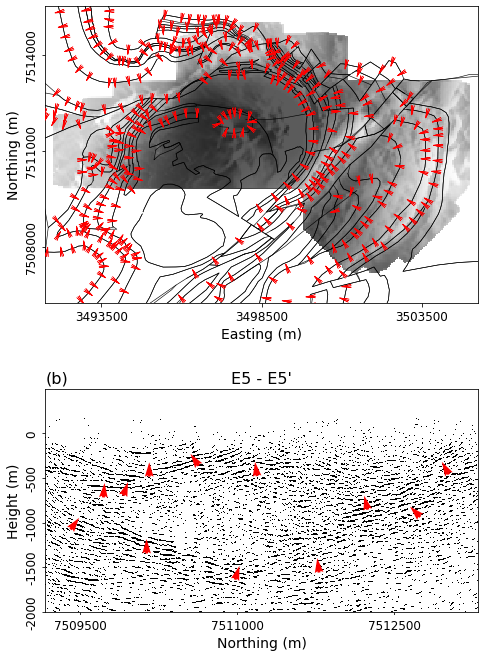

In [54]:
fig = plt.figure(figsize=(8,12))
axs = plt.subplot(2,1,1)

y = [7508000, 7511000, 7514000]
x = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]
zlim = [-2000, 500]
vmin = -5
vmax = 5
zticks = np.arange(-2000,500,500)

plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.6, zorder=4)
# plotGeology(VRTX,faults, ax=axs, faultsOnly=True, fill=False, linewidth=2.)
X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
    survey.srcField.rxList[0].locs[:,0], 
    survey.srcField.rxList[0].locs[:,1], 
    survey.dobs, axs=axs, fill=True, contours=None, minCurvature=False,
                     vmin=vmin, vmax=vmax, resolution=50,
                     clabel=True, cmap='gray_r', ve=500., alpha=0.8, alphaHS=0.2,
                     distMax=100, azdeg=270, altdeg=45,
                     equalizeHist='HistEqualized')

# plt.scatter(survey.rxLoc[:,0], survey.rxLoc[:,1], 0.1, c='k')
# im, CS = plotTopoHillside(np.c_[survey.srcField.rxList[0].locs[:,:2],survey.dobs] ,
#                           axs=axs, cmap='RdBu_r', vmin=vmin, vmax=vmax, distMax=100,
#                           clabel=False,
#                           alpha=1., alphaHS=0.5, ve=20., azdeg=215, altdeg=30)


# plt.plot(hull[:, 0], hull[:, 1], 'k', linewidth=2.)

# axs.plot(3499000, 7512250,'r.',markersize=20)
# axs.text(3499200, 7512250,'Ni-Cu',bbox={'facecolor':'white', 'alpha':0.75},ha='left', va='center', size=14)
# axs.text(3497000, 7511500,'Kevitsa',ha='center', va='center', size=14)
# axs.text(3502000, 7510500,'Satovaara',ha='center', va='center', size=14)
# axs.text(3502500, 7514500,'Koitelainen',ha='center', va='center', size=14)
# axs.text(3497700, 7511800,'UDU',ha='center', va='center', size=10)
# axs.text(3497100, 7512700,'UPXO',ha='center', va='center', size=10)
# axs.text(3496000, 7511500,'IGB',ha='center', va='center', size=10)
# axs.text(3495200, 7510500,'MPHB',ha='center', va='center', size=10)
# axs.text(3498500, 7510000,'MPHB',ha='center', va='center', size=10)

axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=12, ha='center')
axs.set_xlabel('Easting (m)', size=14)

axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=12, va='center', rotation=90)
axs.set_ylabel('Northing (m)', size=14)
axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
# axs.set_position([pos.x0, pos.y0-0.05,  pos.width*1.3, pos.height*1.3])
# axs.set_title('Plan View', fontsize=14)

# pos = axs.get_position()
# axbar = plt.axes([pos.x0+.1, pos.y0-0.1,  pos.width*.75, pos.height*.3])
# cbar = plt.colorbar(im, orientation='horizontal',format='%.1f')
# cbar.set_ticks(np.linspace(vmin,vmax,5))
# cbar.set_label("mGal", size=14)
# # axbar.text(pos.x0, pos.y0-.5,'mGal', size=14)
# axbar.axis('off')


for ind, (loc, vec) in enumerate(zip(locs, vecs)):
    cc = 'r'
#     plt.text(loc[0,0], loc[0,1], str(ind))
    plt.quiver(loc[::3,0], loc[::3,1], vec[::3,0], vec[::3,1], 
                   pivot='mid',
                   scale_units="inches", scale=7.5, linewidths=(0.5),
                   edgecolors=cc,
                   headaxislength=0.1, headwidth=10, headlength=30, zorder=5)
# ax[1].set_xlim([xyzLoc[:,0].min(), xyzLoc[:,0].max()])
# ax[1].set_ylim([xyzLoc[:,1].min(), xyzLoc[:,1].max()])


# Add section with vectors
ax2=plt.subplot(2,1,2)
ax2.set_position([pos.x0, pos.y0-.40, pos.width*1., pos.height*1.])

# ax2=plt.axes([pos.x0+0.5, pos.y0, pos.width*.75, pos.height*.75]) #plt.subplot(3,1,1)
temp = (np.fliplr(DataE5.copy().T))
temp[temp<np.percentile(temp,90)] = 0


temp[temp!=0] = 1

# temp[temp>np.percentile(temp,95)] = 0

model = (temp.T).copy()
# im2 = ax2.imshow(DataE5, cmap="gray_r", origin='lower')
# ax2.set_xlim([100,300])
ax2.set_ylim([700,1100])
ax2.set_aspect('equal')
ax2.set_title("(b)", loc='left', size=14)

X = np.r_[190, 55, 395,195, 150, 110, 510, 360, 690, 280, 750, 600]
Z = np.r_[798, 850, 975, 975, 928, 928, 760, 740, 880, 994, 975, 900] #mkvc(np.arange(50, 800, 100)), mkvc(np.arange(730, 1200, 75))#np.r_[25, 210, 510, 700], np.r_[815, 975]# np.r_[58,70,110,125,140, 160, 170, 200], np.r_[40, 60, 110, 125, 135,150,160, 176, 188]#np.c_[140, 160]#, mkvc(np.linspace(20, 200, 6))# 

vecXZ = getVectors(X, Z, model)

# for ii in range(X.shape[0]):
#     ax2.scatter(meshE5.x0[0] + np.mean(meshE5.hx)*X[ii], meshE5.x0[1] + np.mean(meshE5.hy)*Z[ii], 100, 'g')

# Plot the vector and box
for vec in vecXZ:
    
    normal = np.dot(np.r_[np.c_[0,-1], np.c_[1,0]], vec[2:])
    x, y = meshE5.x0[0] + np.mean(meshE5.hx)*vec[0], meshE5.x0[1] + np.mean(meshE5.hy)*vec[1]
    if normal[1] < 0:
        normal *= -1
        
    ax2.quiver(x, y, 
              normal[0], 
              normal[1], color='r', pivot='middle', width=0.008, scale=30, zorder=3)

#     rec = Rectangle(np.r_[x-winSize, y-winSize], 2*winSize, 2*winSize,
#                     facecolor='none', edgecolor='b', linewidth=2, zorder=2)
#     ax2.add_patch(rec)
    

im2 = meshE5.plotImage(temp, clim=[0,1], ax=ax2, pcolorOpts={"cmap":"gray_r","alpha":1, "clim":[0, 1]}, grid=False)
x = np.arange(7509500, 7514000, 1500)
ax2.set_xticks([llE5[np.argmin(np.abs(yyE5-a))] for a in x])
ax2.set_xticklabels(map(str, map(int,[np.round(yyE5[np.argmin(np.abs(yyE5-a))]/10)*10 for a in x])),size=12, backgroundcolor='w')
ax2.xaxis.get_label().set_backgroundcolor('w')
ax2.set_ylim(zlim)
ax2.set_xlim([0,llE5[-1]])
ax2.set_xlabel("Northing (m)", size=14)
ax2.set_yticks(zticks)
ax2.set_yticklabels(map(str, map(int, zticks)),size=12, rotation=90, va='center')
# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()


ax2.set_ylabel("Height (m)", size=14)
ax2.set_title("(b)", loc="left", size=16)
ax2.set_title("E5 - E5'", loc='center', size=16)
# ax2.set_title("E5'", loc='right', size=16)
ax2.set_aspect('equal')

fig.savefig("Kevitsa_Grav_Constraints_Markers.png", bbox_inches='tight', dpi=300)


In [17]:
# Find boundary cells
bcInd = np.unique(np.hstack(mesh.cellBoundaryInd))

# Assign nearest to the boundary 
bcVal = griddata(pts, vals, (mesh.gridCC[bcInd,0], mesh.gridCC[bcInd,1], mesh.gridCC[bcInd,2]), method='nearest')

# Stack to the points
pts = np.vstack([pts, mesh.gridCC[bcInd,:]])
vals = np.vstack([vals, bcVal])



In [18]:
# Add 2D constraints
locs, vecs = np.vstack(locs), np.vstack(vecs)

ztopo = griddata(topo[:,:2], topo[:,2], (locs[:,0], locs[:,1]), method='linear')

locs = np.c_[locs, ztopo]
vecs = np.c_[vecs, np.ones(vecs.shape[0])*np.nan]
pts = np.vstack([pts, locs])
vals = np.vstack([vals, vecs])

In [19]:

# _, mrx = Utils.modelutils.minCurvatureInterp(
#                                         pts[::5,:], vals[::5,:], 
#                                         mesh = mesh, iterMax=500,
#                                         method='spline', tol=1e-3)
# mout = sdiag(np.sum(mrx[:,:3]**2,axis=1)**-0.5) * mrx[:,:3]


# rbf = Rbf(pts[::10, 0], pts[::10, 1], pts[::10, 2], vals[::10,0])
mx = griddata(pts[~np.isnan(vals[:,0]),:], vals[~np.isnan(vals[:,0]),0], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,1])
my = griddata(pts[~np.isnan(vals[:,1]),:], vals[~np.isnan(vals[:,1]),1], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

# rbf = Rbf(pts[::5, 0], pts[::5, 1], pts[::5, 2], vals[::5,2])
mz = griddata(pts[~np.isnan(vals[:,2]),:], vals[~np.isnan(vals[:,2]),2], (mesh.gridCC[:,0], mesh.gridCC[:,1], mesh.gridCC[:,2]), method='linear')

mout = sdiag((mx**2. + my**2. + mz**2.)**-0.5) * np.c_[mx, my, mz]

In [20]:
mx.shape, mesh.nC

((587784,), 587784)

In [21]:
# Create kdTree and inteprolate on section
tree = cKDTree(mesh.gridCC)


In [13]:
def getSlice(m, mesh2D, ind, r, flip=True, projection=None):
    
    nC = mesh.nC
    
    if m.shape[0] > nC:
        
        mx = m[:nC][ind]
        my = m[nC:2*nC][ind]
        mz = m[2*nC:][ind]
#         if projection is not None:
            
# #             sign = np.sign(np.sum(np.c_[mx, my] * projection, axis=1))
#             mxy = my * projection[:,0]
#             amp = np.linalg.norm(np.c_[mx, my, mz], axis=1)
            
        if flip:
            mx = mkvc((mx.reshape(mesh2D.vnC, order='F')))
            my = mkvc((my.reshape(mesh2D.vnC, order='F')))
            mz = mkvc((mz.reshape(mesh2D.vnC, order='F')))
        
        if projection is not None:
            mSlice = np.r_[mx * projection[:,0] + my * projection[:,1], mz]
        else:
            
            mSlice = np.r_[mx, my, mz]
    else:
        
        if r.ndim > 1:
            mSlice = np.zeros(ind.shape[0])        
            w = np.zeros(ind.shape[0])
            for ii in range(ind.shape[1]):
#                 w += 1./r[:, ii]
                mtemp = m[ind[:, ii]] 
                mtemp[mtemp==-100] = 0
                mSlice += mtemp#/r[:, ii]

            mSlice /= ind.shape[1]
        else:
            mSlice = m[ind]
            
        if flip:
            mSlice = mkvc((mSlice.reshape(mesh2D.vnC, order='F')))
    
    return mSlice

In [23]:
# # Create cell center array of point from the seismic section
# mSliceL2 = mL2[ind]
# mSliceL2[mSliceL2==-100] = 0
# mSliceL2 = mkvc(np.fliplr(mSliceL2.reshape(mesh2D.vnC, order='F')))

# mSliceLp = mLP[ind]
# mSliceLp[mSliceLp==-100] = 0
# mSliceLp = mkvc(np.fliplr(mSliceLp.reshape(mesh2D.vnC, order='F')))

# # Project vectors
# vx = mkvc(np.fliplr(mout[:,0][ind].reshape(mesh2D.vnC, order='F')))
# vy = mkvc(np.fliplr(mout[:,1][ind].reshape(mesh2D.vnC, order='F')))
# vz = mkvc(np.fliplr(mout[:,2][ind].reshape(mesh2D.vnC, order='F')))

# # Get average direction
# dx, dy = np.abs(np.mean(xx[1:]-xx[:-1])), np.abs(np.mean(yy[1:]-yy[:-1]))
# vxy = (vx * dx + vy * dy) / (dx**2. + dy**2.)**0.5

# lvl = (vxy**2. + vz**2.)**0.5
# mvec = np.c_[vxy/lvl, vz/lvl]



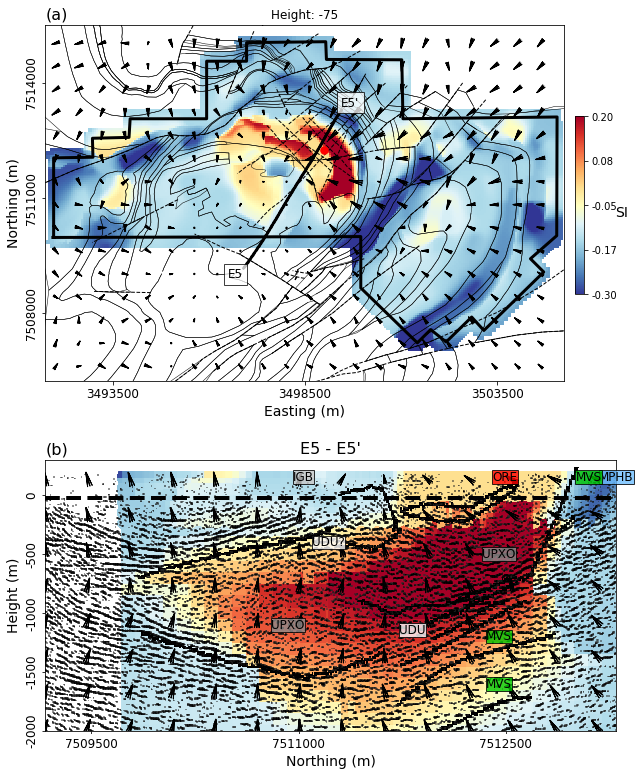

In [24]:
fig=plt.figure(figsize=(10,12))

ii = 0
yy = [7508000, 7511000, 7514000]
xx = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]
zlim = [-2000,300]
zticks = np.arange(-2000,500,500)
zInd = int(np.searchsorted(mesh.vectorCCz, -75))

vmin, vmax = -.3, 0.2
scale = 5
subFact = 60


# Horizontal - Location map
rXY, indXY = tree.query(np.c_[meshXY.gridCC, np.ones(meshXY.nC)*mesh.vectorCCz[zInd]], k=1)

# if mLP is not None:
xySliceLpXY = getSlice(mkvc(mout), meshXY, indXY, rXY, projection=None)
    
    
# mSliceLpE5 = getSlice(mA, meshE5, indE5, rE5)

axs = plt.subplot(2,1,1)# plt.axes([pos.x0 - .39, pos.y0, pos.width, pos.height])
plotGeology(VRTX,[], ax=axs, fill=False, linewidth=0.5, zorder=1)
# axs, im2, cbar = plotModelSections(
#     meshXY, mSliceLpXY, axs=axs, cmap="pink_r", vmin=vmin, vmax=vmax, 
#     alpha=1., colorbar=False, contourf=True)
im2 = mesh.plotSlice(
    mA, normal='Z', ind=zInd, ax=axs, clim=[vmin, vmax],
    pcolorOpts={"cmap":"RdYlBu_r", "vmin":vmin, "vmax":vmax, "alpha":1})
plotGeology(VRTX,faults, faultsOnly=True, ax=axs, linewidth=1.0, zorder=2)

# if mLP is not None:
plotModelSections(
        meshXY, xySliceLpXY, axs=axs, fill=False,
        subFact=int(subFact/5), scale=scale, vec='k')
# im = plotGeology(VRTX,faults, ax=axs)
plt.plot(hull[:, 0], hull[:, 1], 'k', linewidth=3, zorder=5)
axs.plot(3499000, 7512250,'r.',markersize=15)
plt.scatter(xxE5,yyE5,1,c='k')
axs.text(xxE5[0], yyE5[0], 'E5', ha="right", va="top", size=12, bbox={'facecolor':'white', 'alpha':0.75})
axs.text(xxE5[-1], yyE5[-1], "E5'", ha="left", va="bottom", size=12, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE4,yyE4,1,c='k')
# axs.text(xxE4[0], yyE4[0], 'E4', ha="center", va="top", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE4[-1], yyE4[-1], "E4'", ha="center", va="bottom", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.plot(3499000, 7512250,'r.',markersize=20)
# axs.text(3499200, 7512250,'Ni-Cu',bbox={'facecolor':'white', 'alpha':0.75},ha='left', va='center', size=10)
# axs.text(3497700, 7511850,'UDU',ha='center', va='center', size=12)
# axs.text(3497100, 7512700,'UPXO',ha='center', va='center', size=12)
# axs.text(3493800, 7509500,'VS',ha='center', va='center', size=12)
# axs.text(3503000, 7510000,'PDT',ha='center', va='center', size=12)
# axs.text(3497400, 7510600,'IGB',ha='center', va='center', size=12)

axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, xx)))
axs.set_xticklabels(map(str, map(int, xx)),size=12)
axs.set_ylabel('Northing (m)', size=14)
axs.set_xlabel('Easting (m)', size=14)

axs.set_yticks(list(map(int, yy)))
axs.set_yticklabels(map(str, map(int, yy)),size=12, rotation=90, va='center')
axs.grid(True, 'k')
axs.set_aspect('equal')

axs.set_title("(a)", loc="left", size=16)
axs.set_title("Height: %.0f" % mesh.vectorCCz[zInd])
pos = axs.get_position()
axs.set_position([pos.x0-.1, pos.y0, pos.width*1.2, pos.height*1.2])

pos = axs.get_position()
axbar = plt.axes([pos.x0+.43, pos.y0+.1,  pos.width*0.5, pos.height*0.5])
cbar = plt.colorbar(im2[0], orientation='vertical',format='%.2f')
cbar.set_ticks(np.linspace(vmin,0.2,5))
cbar.ax.tick_params(labelsize=10) 
cbar.set_label("SI", size=14, rotation=0)# axbar.text(pos.x0+0.6, pos.y0-1,'SI', size=14)
axbar.axis('off')


# E5 section plot
ax2=plt.subplot(2,1,2)
ax2.set_position([pos.x0, pos.y0-.475, pos.width*1.1, pos.height*1.1])

# ax2=plt.axes([pos.x0+0.5, pos.y0, pos.width*.75, pos.height*.75]) #plt.subplot(3,1,1)
temp = mkvc(np.fliplr(DataE5.T))
temp[temp<np.percentile(temp,85)] = np.nan


rE5, indE5 = tree.query(np.c_[XE5, YE5, ZE5], k=1)

# if mLP is not None:
xySliceLpE5 = getSlice(mkvc(mout), meshE5, indE5, rE5, projection=mxyE5)

mSliceLpE5 = getSlice(mA, meshE5, indE5, rE5)

plotModelSections(
    meshE5, mSliceLpE5, axs=ax2, cmap="RdYlBu_r", vmin=vmin, vmax=vmax, 
    alpha=0.9, colorbar=False, contourf=False, vec='w')
plotModelSections(meshE5,geoSliceE5, axs=ax2, cmap="gray_r", vmin=0, vmax=2, alpha=1, colorbar=False)
im2 = meshE5.plotImage(temp, clim=[-2,2], ax=ax2, pcolorOpts={"cmap":"gray_r","alpha":0.5})

# if mLP is not None:
plotModelSections(
        meshE5, xySliceLpE5, axs=ax2, fill=False,
        subFact=subFact, scale=scale, vec='k')

E2x = llE5[np.argmin(np.abs(xxE5-xx[1]))]
# plt.plot(np.r_[E2x, E2x], zlim, "k--", linewidth=4)
plt.plot(np.r_[llE5.min(), llE5.max()], [mesh.vectorCCz[zInd+1]]*2, "k--", linewidth=4)
ax2.text(E2x-800, -1100, "UPXO", ha="right", va="center", size=12, bbox={'facecolor':cpool['Opx'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x, -1200, "UDU", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['Dunite'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x - 600, -400, "UDU?", ha="center", va="center", size=12, bbox={'facecolor':cpool['Dunite'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x + 850, -500, "UPXO", ha="center", va="center", size=12, bbox={'facecolor':cpool['Opx'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x + 900, 100, "ORE", ha="center", va="bottom", size=12, bbox={'facecolor':'red', 'pad':0.4, 'alpha':0.8})
ax2.text(E2x-900, 100, "IGB", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['Gabbro'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+1700, 100, "MPHB", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['CarbPhy'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+ 850, -1200, "MVS", ha="center", va="center", size=12, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+1500, 100, "MVS", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+ 850, -1600, "MVS", ha="center", va="center", size=12, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})

# x = np.arange(3497150, 3499500, 1000)
x = np.arange(7509500, 7514000, 1500)
ax2.set_xticks([llE5[np.argmin(np.abs(yyE5-a))] for a in x])
ax2.set_xticklabels(map(str, map(int,[np.round(yyE5[np.argmin(np.abs(yyE5-a))]/10)*10 for a in x])),size=12, backgroundcolor='w')
ax2.xaxis.get_label().set_backgroundcolor('w')
ax2.set_ylim(zlim)
ax2.set_xlim([0,llE5[-1]])
ax2.set_xlabel("Northing (m)", size=14)
ax2.set_yticks(zticks)
ax2.set_yticklabels(map(str, map(int, zticks)),size=12, rotation=90, va='center')
# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()


ax2.set_ylabel("Height (m)", size=14)
ax2.set_title("(b)", loc="left", size=16)
ax2.set_title("E5 - E5'", loc='center', size=16)
# ax2.set_title("E5'", loc='right', size=16)
ax2.set_aspect('equal')
# ax2.set_position([pos.x0+0.25, pos.y0, pos.width*.7, pos.height*.7])


fig.savefig("Kevitsa_Grav_Constraints.png", bbox_inches='tight', dpi=300)


In [25]:
mesh.writeUBC(work_dir + 'MeshOctree.msh', {work_dir + 'NormalX.dat':mout[:,0], work_dir + 'NormalY.dat':mout[:,1], work_dir + 'NormalZ.dat':mout[:,2]})
# Utils.io_utils.writeVectorUBC(
#                     mesh, work_dir + 'NormalY.dat', mout[:,1])
# Utils.io_utils.writeVectorUBC(
#                     mesh, work_dir + 'NormalZ.dat', mout[:,2])



# Run the inversion


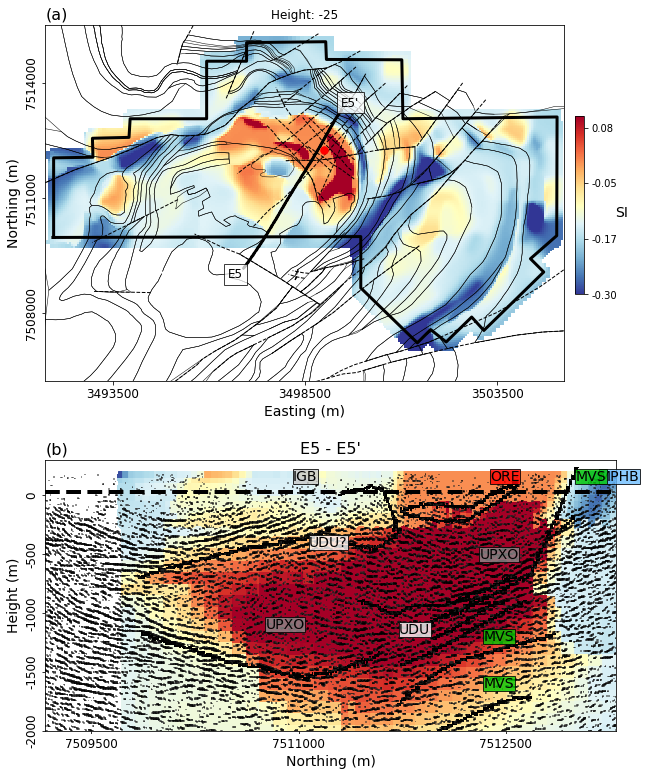

In [29]:
fig=plt.figure(figsize=(10,12))

ii = 0
yy = [7508000, 7511000, 7514000]
xx = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]
zlim = [-2000,300]
zticks = np.arange(-2000,500,500)
zInd = int(np.searchsorted(mesh.vectorCCz, -25))

vmin, vmax = -.3, 0.1
scale = 5
subFact = 60


# Horizontal - Location map
rXY, indXY = tree.query(np.c_[meshXY.gridCC, np.ones(meshXY.nC)*mesh.vectorCCz[zInd]], k=1)

# if mLP is not None:
# xySliceLpXY = getSlice(mkvc(mout), meshXY, indXY, rXY, projection=None)
    
    
# mSliceLpE5 = getSlice(mA, meshE5, indE5, rE5)

axs = plt.subplot(2,1,1)# plt.axes([pos.x0 - .39, pos.y0, pos.width, pos.height])
plotGeology(VRTX,[], ax=axs, fill=False, linewidth=0.5, zorder=1)
# axs, im2, cbar = plotModelSections(
#     meshXY, mSliceLpXY, axs=axs, cmap="pink_r", vmin=vmin, vmax=vmax, 
#     alpha=1., colorbar=False, contourf=True)
im2 = mesh.plotSlice(
    mA, normal='Z', ind=zInd, ax=axs, clim=[vmin, vmax],
    pcolorOpts={"cmap":"RdYlBu_r", "vmin":vmin, "vmax":vmax, "alpha":1})
plotGeology(VRTX,faults, faultsOnly=True, ax=axs, linewidth=1.0, zorder=2)

# if mLP is not None:
# plotModelSections(
#         meshXY, xySliceLpXY, axs=axs, fill=False,
#         subFact=int(subFact/5), scale=scale, vec='k')
# im = plotGeology(VRTX,faults, ax=axs)
plt.plot(hull[:, 0], hull[:, 1], 'k', linewidth=3, zorder=5)
axs.plot(3499000, 7512250,'r.',markersize=15)
plt.scatter(xxE5,yyE5,1,c='k')
axs.text(xxE5[0], yyE5[0], 'E5', ha="right", va="top", size=12, bbox={'facecolor':'white', 'alpha':0.75})
axs.text(xxE5[-1], yyE5[-1], "E5'", ha="left", va="bottom", size=12, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE4,yyE4,1,c='k')
# axs.text(xxE4[0], yyE4[0], 'E4', ha="center", va="top", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE4[-1], yyE4[-1], "E4'", ha="center", va="bottom", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.plot(3499000, 7512250,'r.',markersize=20)
# axs.text(3499200, 7512250,'Ni-Cu',bbox={'facecolor':'white', 'alpha':0.75},ha='left', va='center', size=10)
# axs.text(3497700, 7511850,'UDU',ha='center', va='center', size=12)
# axs.text(3497100, 7512700,'UPXO',ha='center', va='center', size=12)
# axs.text(3493800, 7509500,'VS',ha='center', va='center', size=12)
# axs.text(3503000, 7510000,'PDT',ha='center', va='center', size=12)
# axs.text(3497400, 7510600,'IGB',ha='center', va='center', size=12)

axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, xx)))
axs.set_xticklabels(map(str, map(int, xx)),size=12)
axs.set_ylabel('Northing (m)', size=14)
axs.set_xlabel('Easting (m)', size=14)

axs.set_yticks(list(map(int, yy)))
axs.set_yticklabels(map(str, map(int, yy)),size=12, rotation=90, va='center')
axs.grid(True, 'k')
axs.set_aspect('equal')

axs.set_title("(a)", loc="left", size=16)
axs.set_title("Height: %.0f" % mesh.vectorCCz[zInd])
pos = axs.get_position()
axs.set_position([pos.x0-.1, pos.y0, pos.width*1.2, pos.height*1.2])

pos = axs.get_position()
axbar = plt.axes([pos.x0+.43, pos.y0+.1,  pos.width*0.5, pos.height*0.5])
cbar = plt.colorbar(im2[0], orientation='vertical',format='%.2f')
cbar.set_ticks(np.linspace(vmin,0.2,5))
cbar.ax.tick_params(labelsize=10) 
cbar.set_label("SI", size=14, rotation=0)# axbar.text(pos.x0+0.6, pos.y0-1,'SI', size=14)
axbar.axis('off')


# E5 section plot
ax2=plt.subplot(2,1,2)
ax2.set_position([pos.x0, pos.y0-.475, pos.width*1.1, pos.height*1.1])

# ax2=plt.axes([pos.x0+0.5, pos.y0, pos.width*.75, pos.height*.75]) #plt.subplot(3,1,1)
temp = mkvc(np.fliplr(DataE5.T))
temp[temp<np.percentile(temp,85)] = np.nan


rE5, indE5 = tree.query(np.c_[XE5, YE5, ZE5], k=1)

# if mLP is not None:
# xySliceLpE5 = getSlice(mkvc(mout), meshE5, indE5, rE5, projection=mxyE5)

mSliceLpE5 = getSlice(mA, meshE5, indE5, rE5)

plotModelSections(
    meshE5, mSliceLpE5, axs=ax2, cmap="RdYlBu_r", vmin=vmin, vmax=vmax, 
    alpha=0.9, colorbar=False, contourf=False, vec='w')
plotModelSections(meshE5,geoSliceE5, axs=ax2, cmap="gray_r", vmin=0, vmax=2, alpha=1, colorbar=False)
im2 = meshE5.plotImage(temp, clim=[-2,2], ax=ax2, pcolorOpts={"cmap":"gray_r","alpha":0.5})

# if mLP is not None:
# plotModelSections(
#         meshE5, xySliceLpE5, axs=ax2, fill=False,
#         subFact=subFact, scale=scale, vec='k')

E2x = llE5[np.argmin(np.abs(xxE5-xx[1]))]
# plt.plot(np.r_[E2x, E2x], zlim, "k--", linewidth=4)
plt.plot(np.r_[llE5.min(), llE5.max()], [mesh.vectorCCz[zInd+1]]*2, "k--", linewidth=4)
ax2.text(E2x-800, -1100, "UPXO", ha="right", va="center", size=14, bbox={'facecolor':cpool['Opx'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x, -1200, "UDU", ha="left", va="bottom", size=14, bbox={'facecolor':cpool['Dunite'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x - 600, -400, "UDU?", ha="center", va="center", size=14, bbox={'facecolor':cpool['Dunite'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x + 850, -500, "UPXO", ha="center", va="center", size=14, bbox={'facecolor':cpool['Opx'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x + 900, 100, "ORE", ha="center", va="bottom", size=14, bbox={'facecolor':'red', 'pad':0.4, 'alpha':0.8})
ax2.text(E2x-900, 100, "IGB", ha="left", va="bottom", size=14, bbox={'facecolor':cpool['Gabbro'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+1700, 100, "MPHB", ha="left", va="bottom", size=14, bbox={'facecolor':cpool['CarbPhy'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+ 850, -1200, "MVS", ha="center", va="center", size=14, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+1500, 100, "MVS", ha="left", va="bottom", size=14, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})
ax2.text(E2x+ 850, -1600, "MVS", ha="center", va="center", size=14, bbox={'facecolor':cpool['MaficVol'], 'pad':0.4, 'alpha':0.8})

# x = np.arange(3497150, 3499500, 1000)
x = np.arange(7509500, 7514000, 1500)
ax2.set_xticks([llE5[np.argmin(np.abs(yyE5-a))] for a in x])
ax2.set_xticklabels(map(str, map(int,[np.round(yyE5[np.argmin(np.abs(yyE5-a))]/10)*10 for a in x])),size=12, backgroundcolor='w')
ax2.xaxis.get_label().set_backgroundcolor('w')
ax2.set_ylim(zlim)
ax2.set_xlim([0,llE5[-1]])
ax2.set_xlabel("Northing (m)", size=14)
ax2.set_yticks(zticks)
ax2.set_yticklabels(map(str, map(int, zticks)),size=12, rotation=90, va='center')
# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()


ax2.set_ylabel("Height (m)", size=14)
ax2.set_title("(b)", loc="left", size=16)
ax2.set_title("E5 - E5'", loc='center', size=16)
# ax2.set_title("E5'", loc='right', size=16)
ax2.set_aspect('equal')
# ax2.set_position([pos.x0+0.25, pos.y0, pos.width*.7, pos.height*.7])


fig.savefig("Kevitsa_Grav_Constraints.png", bbox_inches='tight', dpi=300)

